# Proyecto Inteligencia Artificial
### Stefano Aragoni
### Luis Diego Santos
### Carol Arevalo

#### El objetivo del presente proyecto es detectar los tweets que puedan estar relacionados con cyberbulling. Para ello se descargo una base de datos de tweets del 2020. 

### Exploración y Limpieza de Datos
Como primer paso, se importa el archivo a través de distintas librerías. 

In [29]:
#importar librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB

from tqdm import tqdm

from collections import Counter
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\carev\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
#cargar dataset
data = pd.read_csv('cyberbullying_tweets.csv')

# Imprimir las primeras 5 filas
data.head()

# Imprimir las últimas 5 filas
data.tail()

#imprimir la cantidad de filas y columnas
data.shape

(47692, 2)

##### Datos Faltantes
En este caso, primero se analizó si hacían falta datos en el dataset. En este caso, todos los datos estaban almacenados y no habían datos fuera de lugar.

Index([], dtype='object')

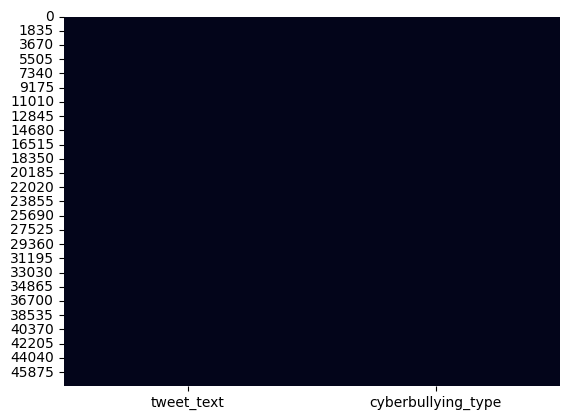

In [31]:
# Matriz de datos faltantes
sns.heatmap(data.isnull(), cbar=False)

# Mostrar columnas con datos faltantes, o con datos fuera de lugar (como un string en columna numérica)
data.columns[data.isnull().any()]

##### Datos Duplicados
Se buscaron datos dupllicados para eliminarlos y tener un modelo más exacto.


In [32]:
#verificar datos duplicados
data.duplicated().sum()

36

In [33]:
#eliminar datos duplicados
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

##### Distribución de clases
Este tipo de análisis es útil para obtener una mejor comprensión de la distribución de los diferentes tipos de ciberacoso en los datos y para identificar los tipos de ciberacoso más comunes en un conjunto de datos.

In [34]:
#distriubución de los datos
data.describe()

,tweet_text,cyberbullying_type
count,47656,47656
unique,46017,6
top,@sschinke @Blackamazon @shanley also sorta wor...,religion
freq,2,7997


In [35]:
# Contar la frecuencia de cada valor único en la columna "cyberbullying_type"
frecuencias = data['cyberbullying_type'].value_counts()

# Mostrar los resultados
print(frecuencias)

religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64


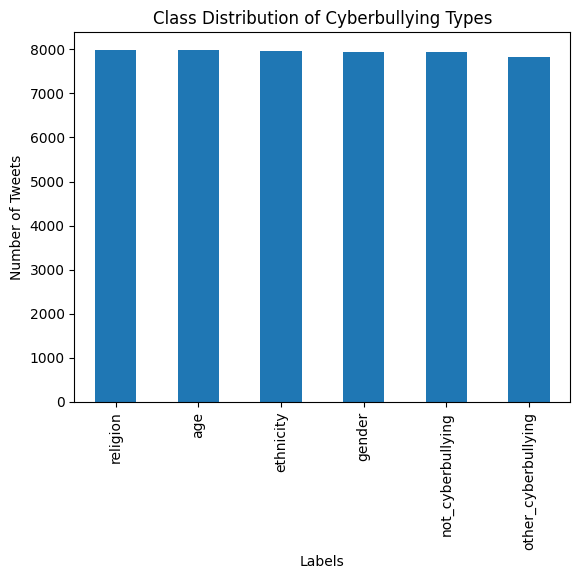

In [36]:
# Create a bar plot of the class distribution
class_counts = data['cyberbullying_type'].value_counts()
class_counts.plot(kind='bar')
plt.title('Class Distribution of Cyberbullying Types')
plt.xlabel('Labels')
plt.ylabel('Number of Tweets')
plt.show()

### Conteo de palabras 
A continuacion se hace un analisis de las palabras mas comunes de la base de datos y se realiza una limpieza de las mismas

In [37]:
# Concatenatar los tweets
all_text = ' '.join(data['tweet_text'].values)

# Remover URLs, menciones y hashtags

all_text = re.sub(r'http\S+', '', all_text)
all_text = re.sub(r'@\S+', '', all_text)
all_text = re.sub(r'#\S+', '', all_text)

# Separar palabras
words = all_text.split()

# eliminar stopwords, es decir palabras que no aportan información
stop_words = set(stopwords.words('english'))
words = [w for w in words if not w in stop_words]

In [38]:
# Frecuencia de cada palabra
word_counts = Counter(words)
top_words = word_counts.most_common(100)
top_words

[('I', 16034),
 ('school', 6681),
 ('like', 5246),
 ('high', 4645),
 ('dumb', 4384),
 ('bullied', 4266),
 ('RT', 4195),
 ('people', 3792),
 ('u', 3238),
 ('rape', 3021),
 ('fuck', 3019),
 ('one', 2786),
 ('bully', 2725),
 ('gay', 2686),
 ('&amp;', 2599),
 ('The', 2522),
 ('get', 2503),
 ('You', 2477),
 ('nigger', 2441),
 ('ass', 2438),
 ('girls', 2377),
 ("I'm", 2316),
 ('girl', 2271),
 ('jokes', 2068),
 ('know', 2021),
 ('think', 1956),
 ('would', 1955),
 ('black', 1868),
 ('white', 1639),
 ('got', 1601),
 ('say', 1511),
 ('make', 1506),
 ('FUCK', 1497),
 ('call', 1480),
 ('even', 1440),
 ('Muslim', 1421),
 ('called', 1420),
 ('And', 1393),
 ('Muslims', 1386),
 ('-', 1371),
 ('never', 1333),
 ('see', 1329),
 ('ur', 1307),
 ('still', 1305),
 ('go', 1299),
 ('This', 1288),
 ('want', 1275),
 ('fucking', 1261),
 ('A', 1261),
 ('really', 1207),
 ('If', 1206),
 ('women', 1181),
 ('joke', 1168),
 ('Christian', 1162),
 ('said', 1130),
 ('right', 1127),
 ('bitch', 1124),
 ('support', 1119),
 (

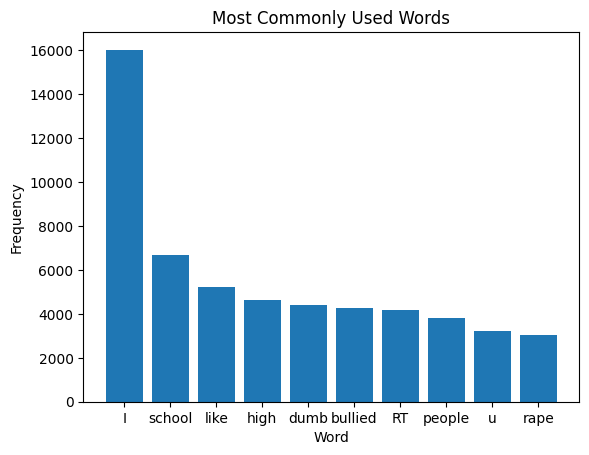

In [39]:
#diagrama de barras de las palabras más frecuentes
top_words = word_counts.most_common(10) 
x_values = [word[0] for word in top_words]
y_values = [word[1] for word in top_words]
plt.bar(x_values, y_values)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words')
plt.show()


### Creacion del Modelo


Como primer paso, se divide el dataset en 80% para entrenamiento, 10% para validación (tuning) y 10% para test

In [40]:
#creacion de la bolsa de palabras

cv = CountVectorizer()
X = cv.fit_transform(data['tweet_text']).toarray()
y = data['cyberbullying_type']



In [41]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Regresion Logisitca


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# train a Logistic Regression Model
clf = LogisticRegression(max_iter = 1000)

clf.fit(X_train, y_train)

# evaluate the classifier on the test set
y_pred = clf.predict(X_test)
y_pred

array(['gender', 'age', 'other_cyberbullying', ..., 'religion',
       'ethnicity', 'religion'], dtype=object)

In [43]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.8272135963071758


In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

## 2. Multinomial Naive Bayes

In [48]:
cv = CountVectorizer()
X = cv.fit_transform(data['tweet_text']).toarray()
y = data['cyberbullying_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo 
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Ecualuar el modelo
X_train_vectorized = cv.transform(X_train)
print("\nExactitud Train:", clf.score(X_train_vectorized, y_train))

X_test_vectorized = cv.transform(X_test)
print("Exactitud Test:", clf.score(X_test_vectorized, y_test))